In [6]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp

import sys
sys.path.insert(0, '../../')
import DLDMD as dl
import LossDLDMD as lf
import Data as dat

%matplotlib inline

In [7]:
def edmd(x, num_pred):
    x = tf.transpose(x, perm=[0, 2, 1])
    x_m = x[:, :, :-1]
    x_p = x[:, :, 1:]
    
    S, U, V = tf.linalg.svd(x_m, compute_uv=True, full_matrices=False)
    sm = np.max(S)
    r = S.shape[-1]
    Sri = tf.linalg.diag(1./S[:, :r])
    Ur = U[:, :, :r]
    Urh = tf.linalg.adjoint(Ur)
    Vr = V[:, :, :r]
    
    kmat = x_p @ Vr @ Sri @ Urh
    evals, evecs = tf.linalg.eig(kmat)
    phim = tf.linalg.solve(evecs, tf.cast(x_m, dtype=tf.complex128))
    x0 = phim[:, :, 0]
    x0 = x0[:, :, tf.newaxis]
    
    pred = tf.TensorArray(tf.complex128, size=num_pred)
    pred = pred.write(0, evecs @ x0)
    evals_iter = tf.identity(evals)
    for ii in range(num_pred):
        tmp = evecs @ tf.linalg.diag(evals_iter) @ x0
        pred = pred.write(ii, tmp)
        evals_iter = evals_iter * evals
    pred = tf.transpose(tf.squeeze(pred.stack()), perm=[1, 2, 0])
    return phim, evals, evecs, pred

In [8]:
def hankel_dmd(Y):
    Y = np.transpose(Y, [0, 2, 1])
#     print("shape of Y: ", np.shape(Y))
    nobs = 2
    winsize = model.num_time_steps - (nobs - 1)
    # Perform DMD method.  Note, we need to be careful about how we break the concatenated Hankel matrix apart.

    gm = tf.Variable(tf.zeros([nobs*hyp_params['phys_dim'], hyp_params['batch_size'] * (winsize - 1)], dtype=hyp_params['precision']))
    gp = tf.Variable(tf.zeros([nobs*hyp_params['phys_dim'], hyp_params['batch_size'] * (winsize - 1)], dtype=hyp_params['precision']))

#     print("gm shape: ", gm.shape)
#     print("gp shape: ", gp.shape)
    for jj in range(hyp_params['phys_dim']):
        Yobserved = (tf.squeeze(Y[:, jj, :])).numpy()
        for ll in range(hyp_params['batch_size']):
            tseries = Yobserved[ll, :]
            tcol = tseries[:nobs]
            trow = tseries[(nobs - 1):]
            hmat = np.flipud(sp.linalg.toeplitz(tcol[::-1], trow))

#             print("hmat shape: ", np.shape(hmat))
#             print("nobs: ", nobs)
#             print("winsize: ", winsize)
            gm[jj*nobs:(jj+1)*nobs, ll * (winsize - 1):(ll + 1) * (winsize - 1)].assign(hmat[:, :-1])
            gp[jj*nobs:(jj+1)*nobs, ll * (winsize - 1):(ll + 1) * (winsize - 1)].assign(hmat[:, 1:])

    sig, U, V = tf.linalg.svd(gm, compute_uv=True, full_matrices=False)
    sig_inv = tf.linalg.diag(1.0 / sig)
    Uh = tf.linalg.adjoint(U)
    gpV = gp @ V
    A = gpV @ sig_inv @ Uh
    evals, evecs = tf.linalg.eig(A)
    phi = tf.linalg.solve(evecs, tf.cast(gm, dtype=tf.complex128))

    normgp = tf.norm(gp, ord='fro', axis=[-2, -1])
    normgpV = tf.norm(gpV, ord='fro', axis=[-2, -1])
    dmdloss = tf.math.sqrt(normgp**2. - normgpV**2.)/tf.math.sqrt(tf.cast(hyp_params['batch_size']*(winsize-1), dtype=hyp_params['precision']))

    # Build reconstruction
    phiinit = phi[:, ::(winsize-1)]
    initconds = tf.cast(tf.transpose(tf.squeeze(Y[:, :, 0])), dtype=tf.complex128)
    sigp, Up, Vp = tf.linalg.svd(phiinit, compute_uv=True, full_matrices=False)
    sigp_inv = tf.cast(tf.linalg.diag(1.0 / sigp), dtype=tf.complex128)
    kmat = initconds @ Vp @ sigp_inv @ tf.linalg.adjoint(Up)
    recon = tf.reshape(tf.transpose(tf.math.real(kmat @ phi)), [hyp_params['batch_size'], winsize-1, hyp_params['phys_dim']])
    # comment out dmdloss from return
    return recon, evals, evecs, phi, dmdloss

# Setup

In [9]:
# Figure parameters
plot_save_path = './analysis_results/'
font = {'family': 'DejaVu Sans', 'size': 18}
matplotlib.rc('font', **font)
fontsize = 18
figsize = (15, 10)
dpisave = 300

# Initialize the compute device
DEVICE = '/GPU:0'
GPUS = tf.config.experimental.list_physical_devices('GPU')
if GPUS:
    try:
        for gpu in GPUS:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    DEVICE = '/CPU:0'

tf.keras.backend.set_floatx('float64')
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Num GPUs available: {}".format(len(GPUS)))
print("Running on device: {}".format(DEVICE))

TensorFlow version: 2.6.0
Eager execution: True
Num GPUs available: 0
Running on device: /CPU:0


# Load model and data

In [10]:
# SET THIS PATH (w/o file extension!). Both '.pkl' and '.h5' files should have same name
model_path = './trained_models/duffing_2022-04-04-1058/epoch_100_loss_-2.27'
model_hyp_params = model_path + '.pkl'
model_weights = model_path + '.h5'

# Load the hyper parameters
hyp_params = pickle.load(open(model_hyp_params, 'rb'))

# Set Tensorflow backend precision
tf.keras.backend.set_floatx(hyp_params['precision'])
print("Using precision: {}\n".format(tf.keras.backend.floatx()))

# Load test data
test_data = pickle.load(open('data_test.pkl', 'rb'))
print("Test data shape: {}".format(test_data.shape))

Using precision: float64

Test data shape: (2000, 401, 2)


In [13]:
# Generate some evenly spaced initial conditions
nsteps = int(hyp_params['time_final'] / hyp_params['delta_t'])
n_ic = int(40)
icond1 = np.ones(shape=(n_ic, 1))
icond1[:20] = icond1[:20]*-1
icond2 = np.linspace(-1, 1, n_ic)
data_mat = np.zeros((n_ic, 2, nsteps+1), dtype=np.float64)
for ii in range(n_ic):
    data_mat[ii, :, 0] = np.array([icond1[ii], icond2[ii]], dtype=np.float64)
    for jj in range(nsteps):
        data_mat[ii, :, jj+1] = dat.rk4(data_mat[ii, :, jj], hyp_params['delta_t'], dat.dyn_sys_duffing)
data = np.transpose(data_mat, [0, 2, 1])
data = tf.cast(data, dtype=hyp_params['precision'])
test_data = data
print(test_data.shape)

(40, 401, 2)


/Users/andrew/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  if __name__ == '__main__':


In [14]:
# Fix hyper parameters for running the model on test data
hyp_params['pretrain'] = False
hyp_params['batch_size'] = test_data.shape[0]

# Load the trained DLDMD model weights
model = dl.DLDMD(hyp_params)
model(test_data)
model.load_weights(model_weights)

# Initialize the loss function
loss = lf.LossDLDMD(hyp_params)
print("Number of prediction steps: ", model.num_pred_steps)

Number of prediction steps:  401


# Run the trained model

In [15]:
with tf.device(DEVICE):
    preds = model(test_data, training=False)
    losses = loss(preds, test_data)

# [y, x_ae, x_adv, y_adv, weights, evals, evecs, phi] = preds
[y, x_ae, x_adv, y_adv, weights, evals, evecs, phi, dmdloss] = preds
print("Loss: {loss:2.7f}".format(loss=losses.numpy()))
print("Log10 Loss: {loss:2.7f}".format(loss=np.log10(losses.numpy())))

Loss: 0.0038348
Log10 Loss: -2.4162536


# Run standard DMD

In [16]:
# EDMD on the unencoded data
# [phim, evals, evecs, x_dmd] = edmd(test_data, num_pred=test_data.shape[1])
# print(np.shape(x_dmd))
# x_dmd = np.real(tf.transpose(x_dmd, perm=[0, 2, 1]))
# print(np.shape(x_dmd))

In [17]:
[x_dmd, evals, evecs, phim, dmdloss] = hankel_dmd(test_data)
print(np.shape(x_dmd))

(40, 399, 2)


# Visualize results

/Users/andrew/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.


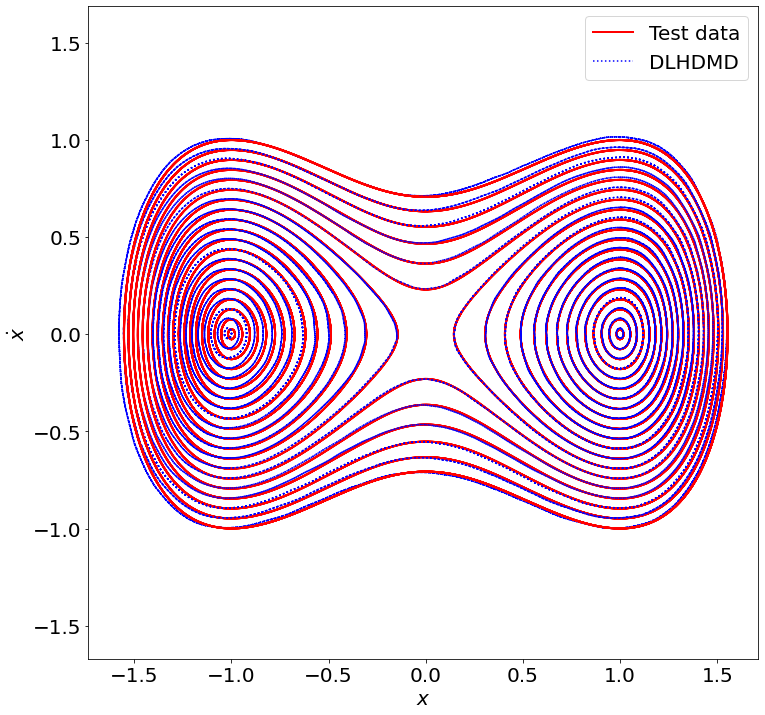

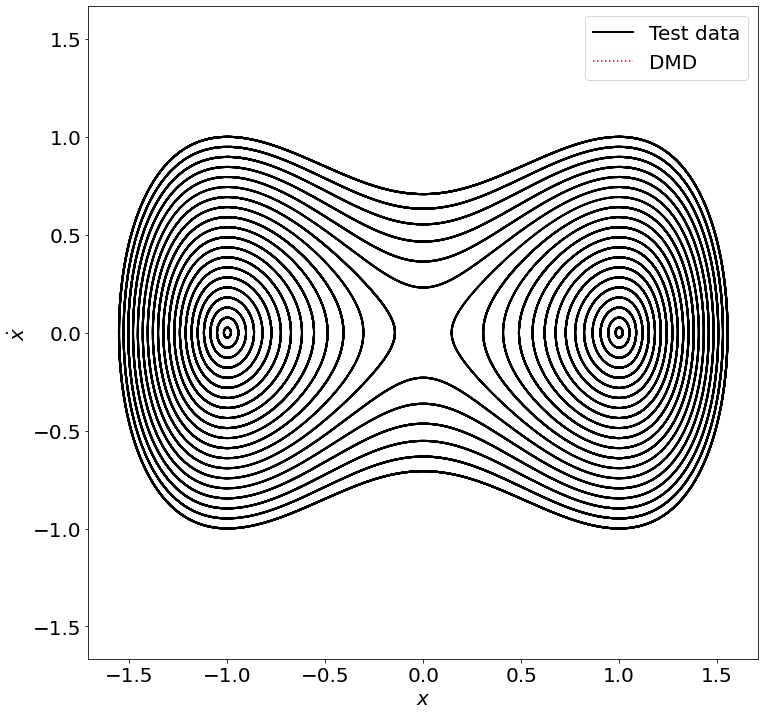

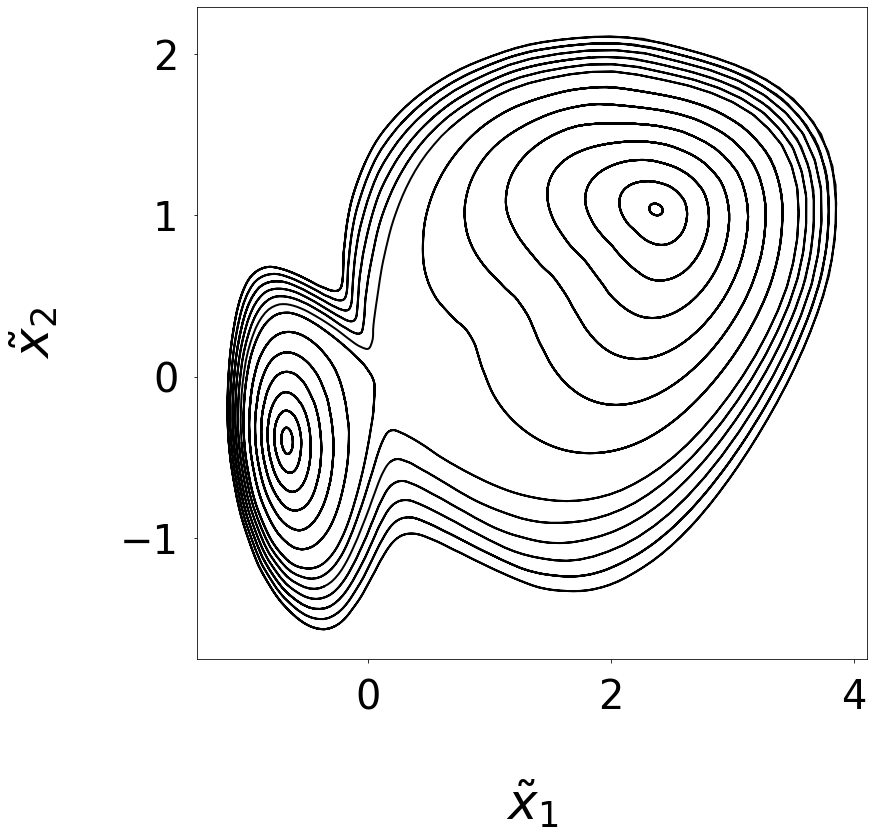

In [21]:
fs = 20
ts = 20
lw = 2.0
ms = 20.0
figsize = (12, 12)
skip = 1

# DLDMD reconstruction
fig = plt.figure(1, figsize=figsize)
for ii in range(0, test_data.shape[0], skip):
    plt.plot(test_data[ii, :, 0], test_data[ii, :, 1], color='red', linestyle='solid', lw=lw)
    plt.plot(x_adv[ii, :, 0], x_adv[ii, :, 1], color='blue', linestyle='dotted', ms=ms)
plt.plot(test_data[ii, :, 0], test_data[ii, :, 1], color='red', linestyle='solid', lw=lw, label='Test data')
plt.plot(x_adv[ii, 0, 0], x_adv[ii, 0, 1], color='blue', linestyle='dotted', ms=20*ms, label='DLHDMD')
plt.xlabel(r'$x$', fontsize=fs)
plt.ylabel(r'$\dot{x}$', fontsize=fs)
plt.legend(fontsize=fs, loc='upper right')
plt.axis('equal')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ts)
ax.tick_params(axis='both', which='minor', labelsize=ts)
# plt.savefig("reconstruction_duffing.png")

# DMD reconstruction
fig = plt.figure(2, figsize=figsize)
for ii in range(0, test_data.shape[0], skip):
    plt.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'k', linestyle='solid', lw=lw)
    plt.plot(x_dmd[ii, :, 0], x_dmd[ii, :, 1], 'k', linestyle='dotted', ms=ms)
plt.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'k', linestyle='solid', lw=lw, label='Test data')
plt.plot(x_dmd[ii, 0, 0], x_dmd[ii, 0, 1], 'k', color='red', linestyle='dotted', ms=20*ms, label='DMD')
plt.xlabel(r'$x$', fontsize=fs)
plt.ylabel(r'$\dot{x}$', fontsize=fs)
plt.legend(fontsize=fs)
plt.axis('equal')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ts)
ax.tick_params(axis='both', which='minor', labelsize=ts)

# Plot trajectories in the latent space
skip = 2
fig = plt.figure(2, figsize=figsize)
for ii in range(0, test_data.shape[0], skip):
    plt.plot(test_data[ii, :, 0], test_data[ii, :, 1], 'k', linestyle='solid', lw=lw)
plt.xlabel(r'$x$', fontsize=fs)
plt.ylabel(r'$\dot{x}$', fontsize=fs)
plt.axis('equal')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ts)
ax.tick_params(axis='both', which='minor', labelsize=ts)

# from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=figsize)
# ax = fig.add_subplot(1, 1, 1, projection='3d')
for ii in range(0, y_adv.shape[0], skip):
    plt.plot(y[ii, :, 0], y[ii, :, 1], 'k', linestyle='solid', lw=lw)
plt.xlabel(r'$\tilde{x}_{1}$', fontsize=50, labelpad=60.0)
plt.ylabel(r'$\tilde{x}_{2}$', fontsize=50, labelpad=60.0)
ax = plt.gca()
ax.tick_params(axis='x', labelsize=40, pad=15)
ax.tick_params(axis='y', labelsize=40, pad=15)
# plt.savefig("latent_duffing.png")
# ax.set_xticks(np.linspace(-0.05, 0.1, 4))
# plt.gca().view_init(20, 160)

plt.show()

In [ ]:
    def lorenz(t, X, sigma=10, beta=2.667, rho=28):
        u, v, w = X
        up = -sigma * (u - v)
        vp = rho * u - v - u * w
        wp = -beta * w + u * v
        return up, vp, wp
    icx = np.random.uniform(0, 1, hyp_params['num_init_conds'])
    icy = np.random.uniform(0, 1, hyp_params['num_init_conds'])
    icz = np.random.uniform(0, 1, hyp_params['num_init_conds'])
    tspan = np.array([0, hyp_params['time_final']])
    dts = np.arange(0, hyp_params['time_final'], hyp_params['delta_t'])
    X = np.zeros(shape=(hyp_params['num_init_conds'], 3, hyp_params['num_time_steps']))

    for ii, ic in enumerate(zip(icx, icy, icz)):
        tmp = solve_ivp(lorenz, t_span=tspan, y0=ic, method='RK45', t_eval=dts)
        X[ii, :, :] = tmp.y
    data = tf.transpose(X, perm=[0, 2, 1])